From https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/demo/segmentation/Segmentation_3D.ipynb

Tweaked to handle different images

In [1]:
from skimage.io import imread, imshow
import matplotlib.pyplot as plt

parent_dir = "D:\\elephasbio\\2021-05-14 Day 3 VD2 EMT-6 fragments\\fragments-001\\";
file_name = "cropped.tif"

input_image=imread(parent_dir+file_name)
input_image=input_image.astype('uint8')
voxel_size_x = 0.2
voxel_size_y = 0.2
voxel_size_z = 1

print(input_image.shape)
print(input_image.dtype)

(19, 310, 382)
uint8


In [2]:
import pyclesperanto_prototype as cle

# select a specific OpenCL / GPU device and see which one was chosen
cle.select_device('RTX')

<GeForce RTX 3090 on Platform: NVIDIA CUDA (1 refs)>

(19, 310, 382)


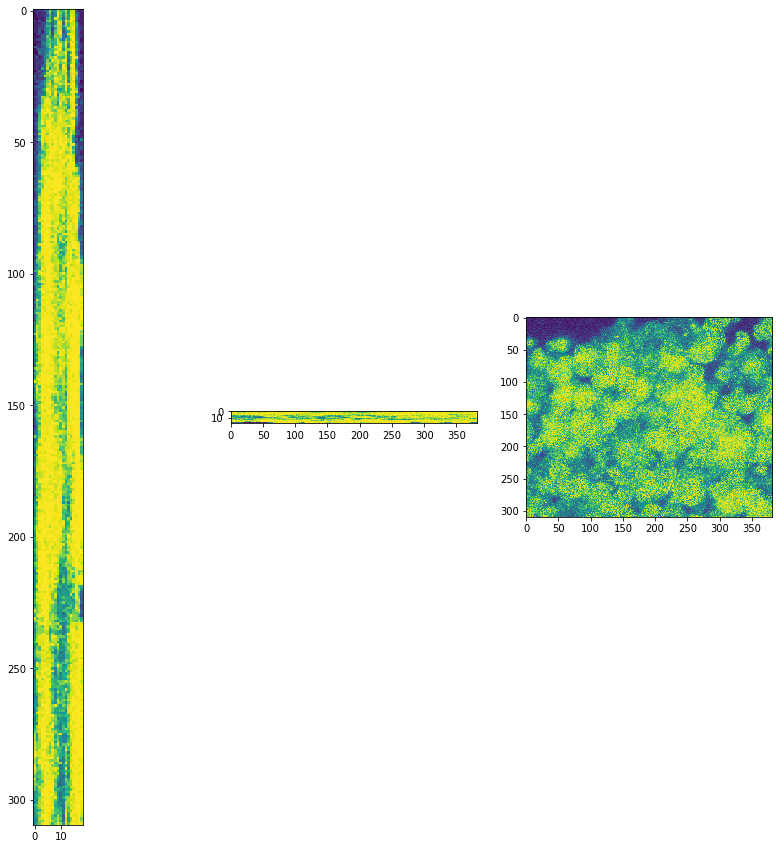

In [3]:
input_gpu = cle.push(input_image)

def show(image_to_show, labels=False):
    """
    This function generates three projections: in X-, Y- and Z-direction and shows them.
    """
    projection_x = cle.maximum_x_projection(image_to_show)
    projection_y = cle.maximum_y_projection(image_to_show)
    projection_z = cle.maximum_z_projection(image_to_show)

    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    cle.imshow(projection_x, plot=axs[0], labels=labels)
    cle.imshow(projection_y, plot=axs[1], labels=labels)
    cle.imshow(projection_z, plot=axs[2], labels=labels)

show(input_gpu)
print(input_gpu.shape)

(19, 62, 76)


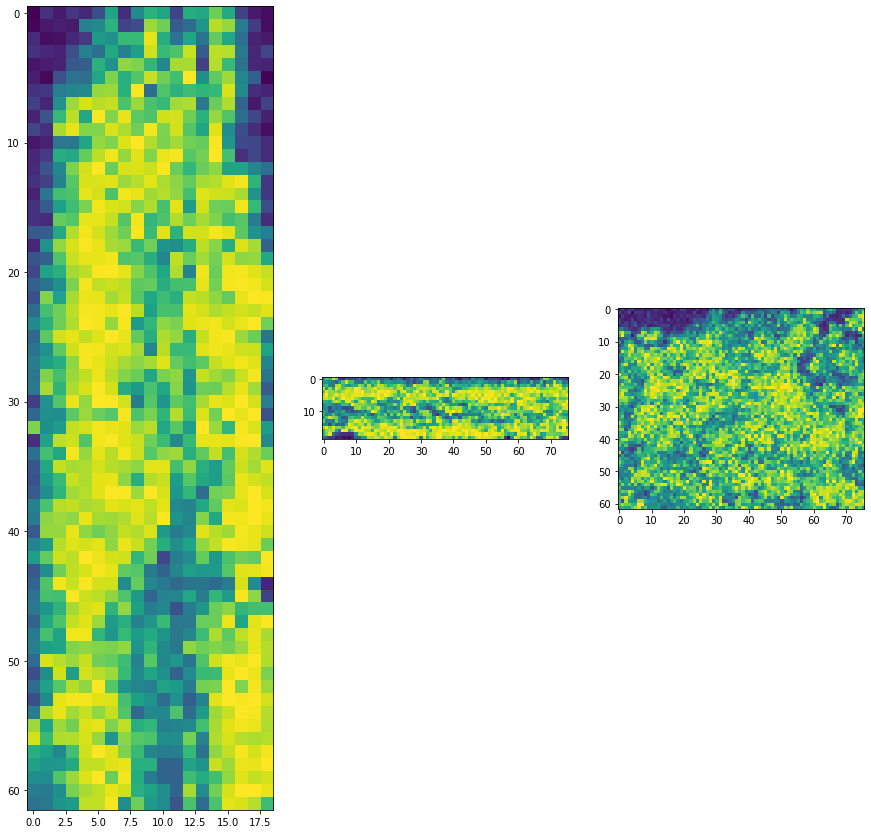

In [4]:
resampled = cle.create([int(input_gpu.shape[0] * voxel_size_z), int(input_gpu.shape[1] * voxel_size_y), int(input_gpu.shape[2] * voxel_size_x)])
cle.scale(input_gpu, resampled, factor_x=voxel_size_x, factor_y=voxel_size_y, factor_z=voxel_size_z, centered=False)

show(resampled)
print(resampled.shape)

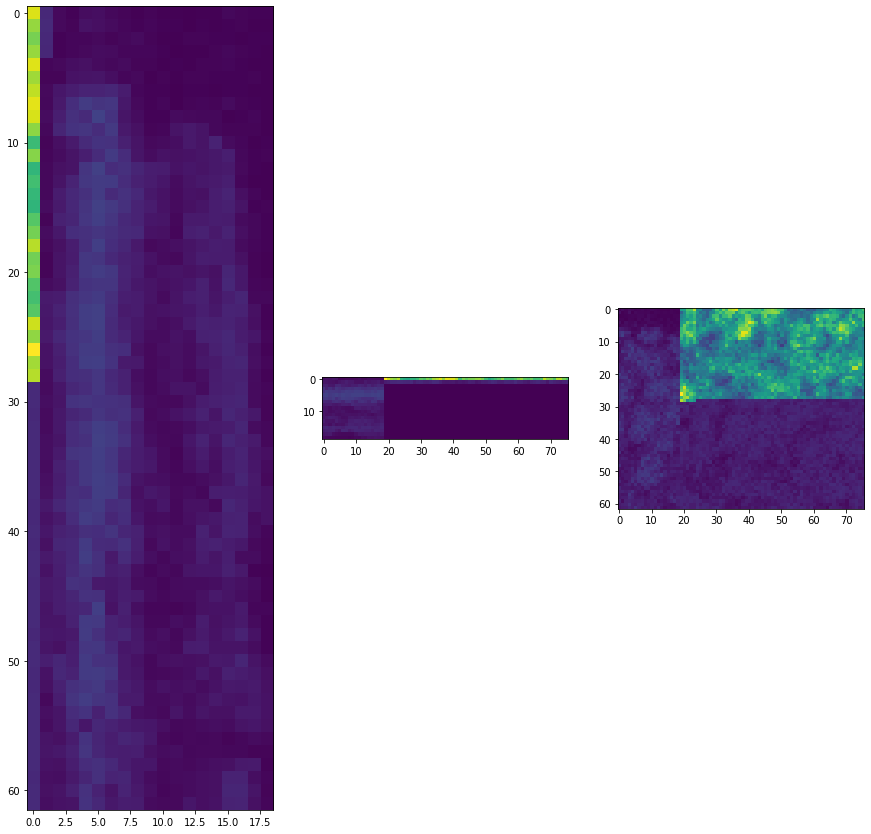

In [7]:
equalized_intensities_stack = cle.create_like(resampled)
a_slice = cle.create([resampled.shape[1], resampled.shape[0]])

num_slices = resampled.shape[0]
mean_intensity_stack = cle.mean_of_all_pixels(resampled)

corrected_slice = None
for z in range(0, num_slices):
    # get a single slice out of the stack
    cle.copy_slice(resampled, a_slice, z)
    # measure its intensity
    mean_intensity_slice = cle.mean_of_all_pixels(a_slice)
    # correct the intensity
    correction_factor = mean_intensity_slice/mean_intensity_stack
    corrected_slice = cle.multiply_image_and_scalar(a_slice, corrected_slice, correction_factor)
    # copy slice back in a stack
    cle.copy_slice(corrected_slice, equalized_intensities_stack, z)

show(equalized_intensities_stack)

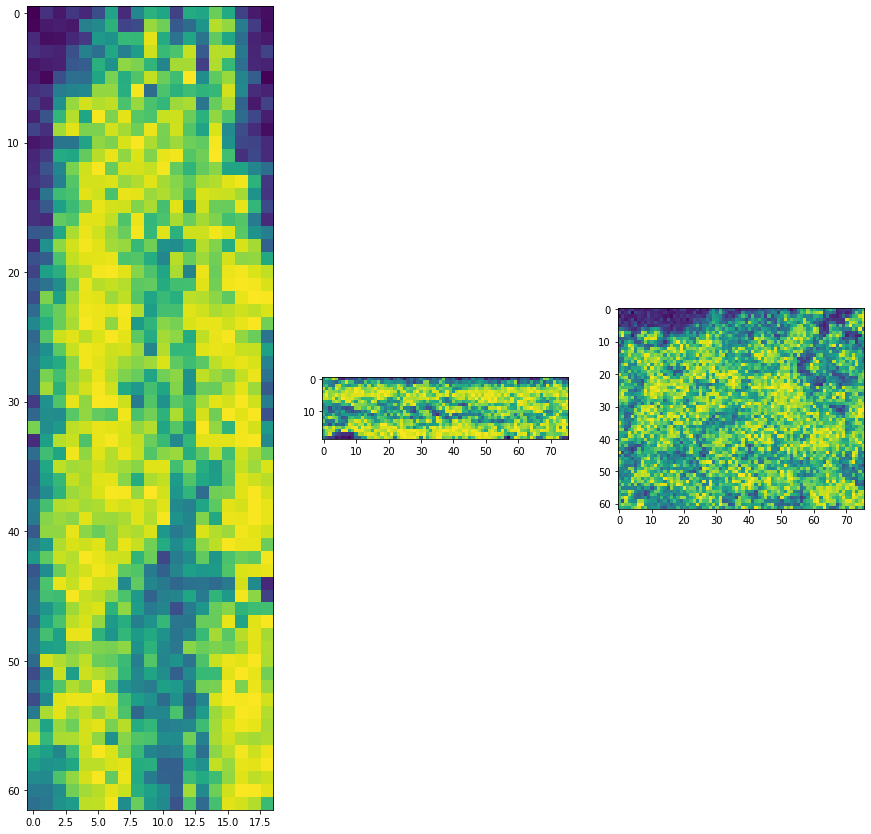

In [5]:
backgrund_subtracted = cle.top_hat_box(resampled, radius_x=5, radius_y=5, radius_z=5)
show(backgrund_subtracted)

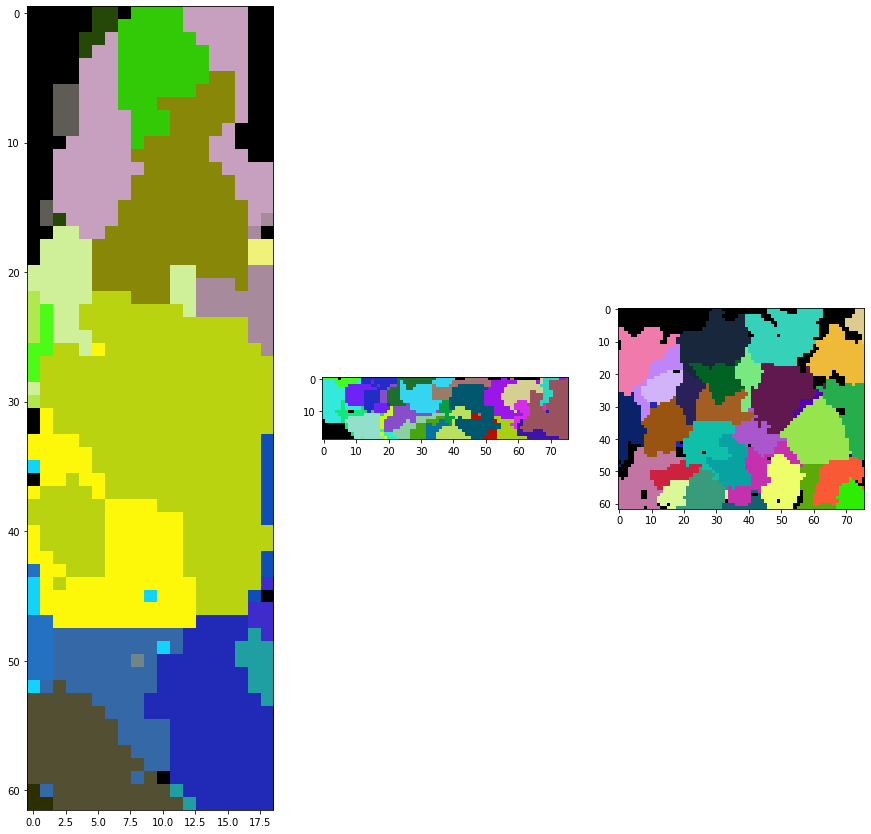

In [6]:
segmented = cle.voronoi_otsu_labeling(backgrund_subtracted, spot_sigma=3, outline_sigma=1)
show(segmented, labels=True)

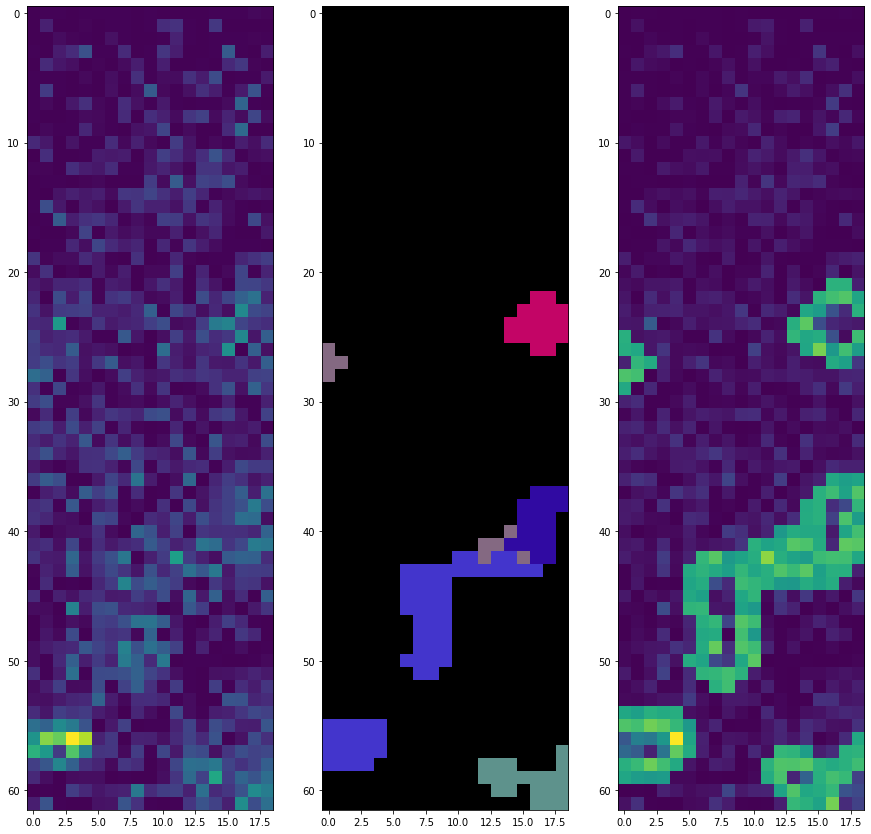

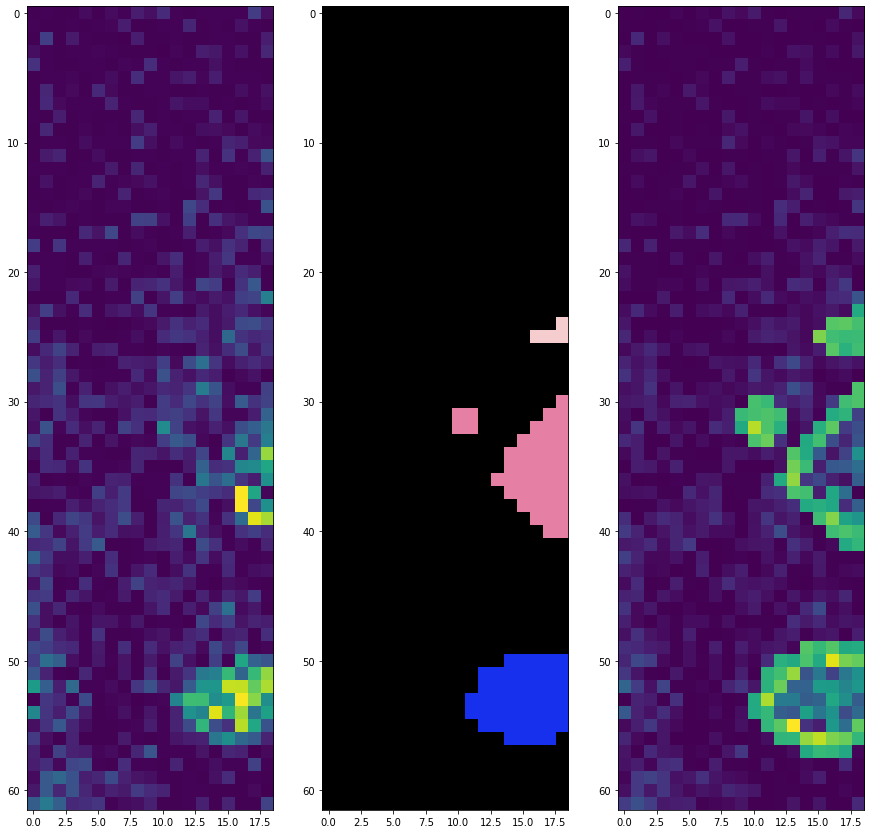

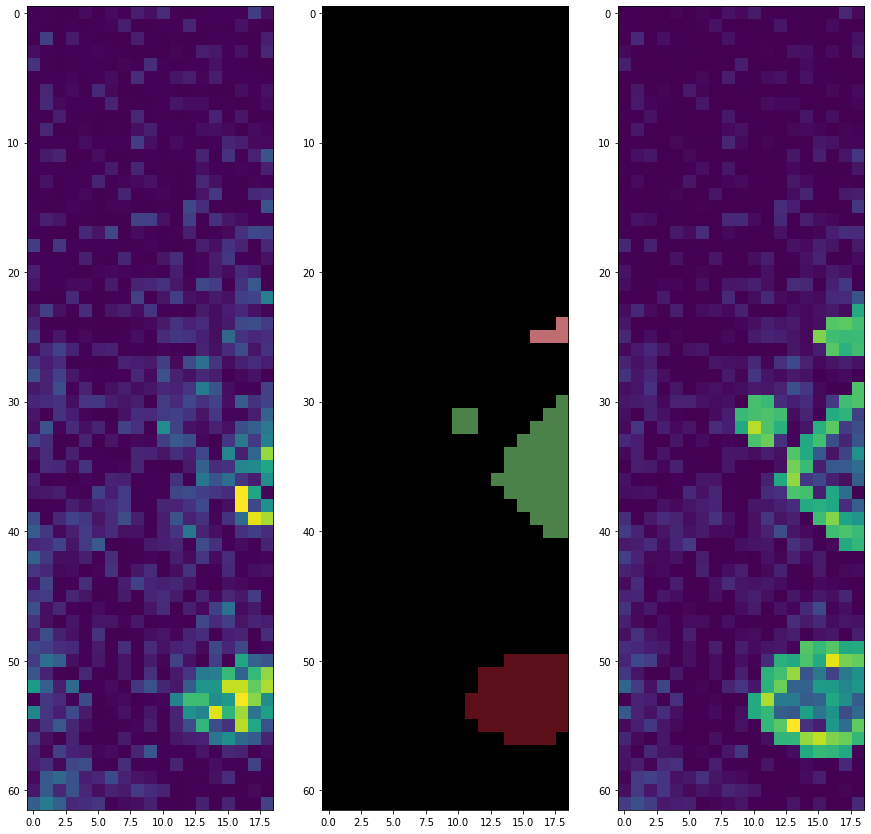

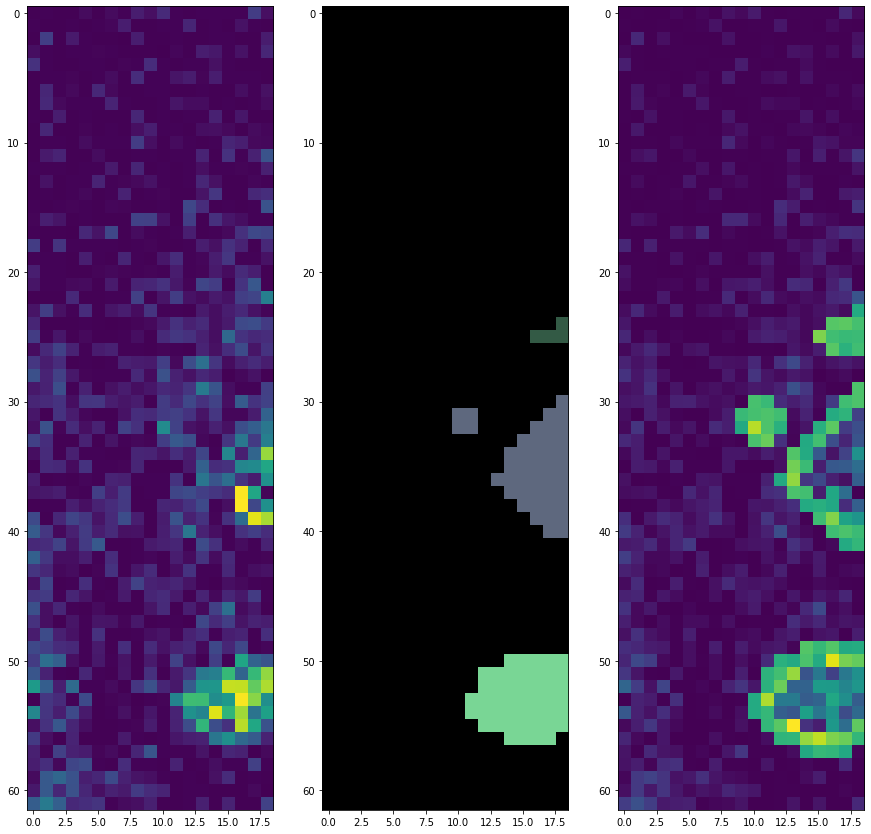

In [11]:
a_slice = cle.create([resampled.shape[1], resampled.shape[0]])
segmented_slice = cle.create([resampled.shape[1], resampled.shape[0]])

for z in range(0, resampled.shape[2], 20):
    label_outlines = None
    combined = None

    # get a single slice from the intensity image and the segmented label image
    cle.copy_slice(resampled, a_slice, z)
    cle.copy_slice(segmented, segmented_slice, z)

    # determine outlines around labeled objects
    label_outlines = cle.detect_label_edges(segmented_slice, label_outlines)

    # combine both images
    outline_intensity_factor = cle.maximum_of_all_pixels(a_slice)
    combined = cle.add_images_weighted(a_slice, label_outlines, combined, 1.0, outline_intensity_factor)

    # visualisation
    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    cle.imshow(a_slice, plot=axs[0])
    cle.imshow(segmented_slice, plot=axs[1], labels=True)
    cle.imshow(combined, plot=axs[2])

In [8]:
# start napari
import napari
viewer = napari.Viewer()

# show images
viewer.add_image(cle.pull(resampled))
viewer.add_image(cle.pull(backgrund_subtracted))
viewer.add_labels(cle.pull(segmented))

C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\abc.py:123: RuntimeWarning: coroutine 'get_msg' was never awaited
  return _abc_subclasscheck(cls, subclass)
Exception in callback BaseAsyncIOLoop._handle_events(4656, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(4656, 1)>
Traceback (most recent call last):
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\site-packages\tornado\platform\asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\site-packages\zmq\eventloop\zmqstream.py", line 448, in _handle_events
    self._handle_recv()
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\site-packages\zmq\eventloop\zmqstream.py", line 477, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\site-pa

<Labels layer 'Labels' at 0x1e6a09c1bb0>